In [156]:
import pickle
import numpy as np
import scipy.ndimage

track = pickle.load(open("mario_track_1.pkl"))

In [63]:
def thresholds(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    max_v = min(vals)
    min_v = max(vals)
    thresholds = set([0, min_v, max_v])
    for t, v in enumerate(vals):
        if (t - last_diff_t) == t_window:
            thresholds.add(last_diff)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return thresholds

axis = 1
window = 3

velocities = track[1:,axis]-track[:-1,axis] 
print velocities
print np.convolve(velocities, np.ones(window)/window, mode='valid')

thresholds(velocities)

[ 2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2

{-5.0, -1.0, 0, 3.0}

In [111]:
def samey_intervals(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    intervals = []
    for t, v in enumerate(vals):
        if ((t - last_diff_t) >= t_window) and v != last_diff:
            intervals.append(last_diff_t)
            intervals.append(t)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return intervals

axis = 1
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)

print velocities
print smoothed

print samey_intervals(velocities)
print samey_intervals(smoothed)

[ 2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.
  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2.  3.  2

In [125]:
def zero_crossings(vals):
    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]
    for t, v in enumerate(vsigns):
        if last_sign == 0:
            last_sign = v
        elif v == 0 or v == last_sign:
            continue
        elif v != last_sign:
            sign_intervals.append(last_sign_change)
            sign_intervals.append(t)
            last_sign = v
            last_sign_change = t
    if t - 1 != last_sign_change:
        sign_intervals.append(last_sign_change)
        sign_intervals.append(t)
    return sign_intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)

print velocities
print smoothed

print zero_crossings(velocities)
print zero_crossings(smoothed)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  5.  5.  5.  4.  4.  4.  4.  4.
  3.  4.  3.  3.  3.  3.  3.  2.  3.  2.  1.  1.  1.  0. -1. -1. -2. -2.
 -3. -3. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.  4.  3.
  3.  2.  2.  1.  1.  0. -1. -1. -1. -2. -3. -3. -4. -5.  5.  5.  5.  5.
  4.  4.  3.  3.  2. -1. -1. -1. -2. -3. -3. -4. -4. -4. -4. -4. -4. -1.
  5.  5.  5.  3.  3.  3.  2.  2.  0.  1.  0.  3.  5.  5.  5.  5.  4.  4.
  4.  4.  4.  3.  4.  3.  3.  3.  3.  3.  2.  3.  2.  1.  1.  1.  0. -1.
 -1. -2. -2. -3. -3. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.  0.  5.  5.  5.  5.  4.  4.  4.
  4.  4.  3.  4.  3.  3.  3.  3.  2.  1.  1.  0. -1. -1. -1. -2. -3. -3.
 -4.  5.  5.  5.  5.  4.  4.  4.  4.  4.  3.  4.  3.  3.  3.  3.  3.  2.
  3.  2.  2.  2.  1.  2.  1.  2.  1.  1.  0.  1.  1.  0.  0. -1. -2. -2.
 -2. -3. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.  4

TypeError: unsupported operand type(s) for |=: 'set' and 'list'

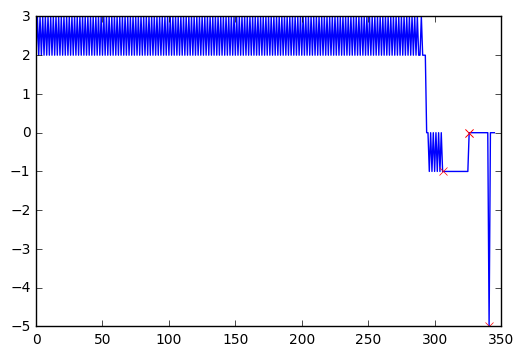

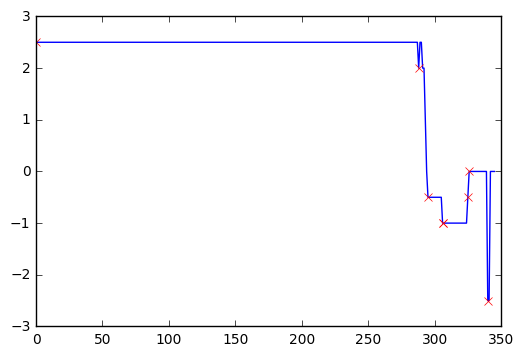

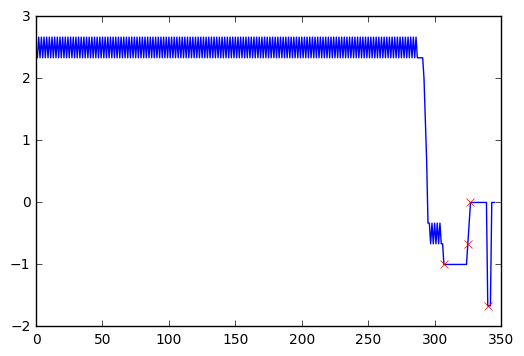

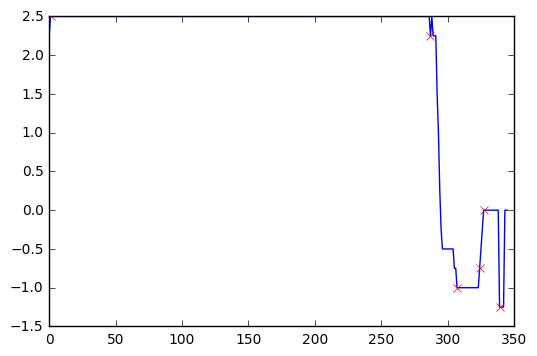

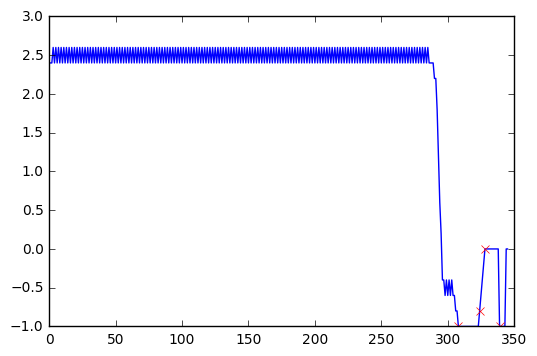

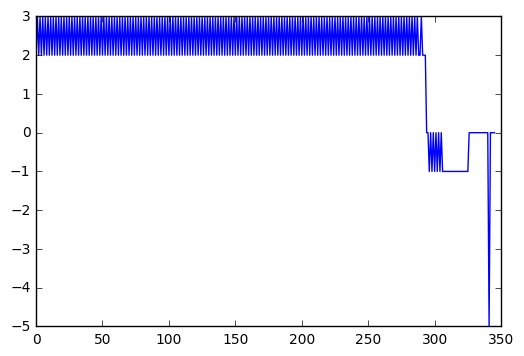

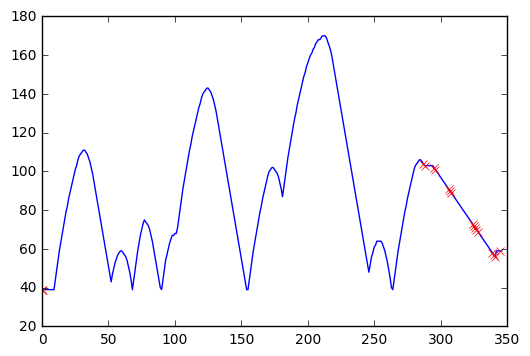

In [151]:
axis = 1

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 10

switch_points = set([])
switch_points |= set(zero_crossings(velocities))
for w in range(1,6):
    smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(w)/w)
    #print smoothed
    plt.plot(smoothed)
    
    points = samey_intervals(smoothed,t_window=same_window)
    plt.plot(np.array(points),smoothed[np.array(points,dtype='int')],'rx')
    plt.show()
    switch_points |= set(points)


switch_points = sorted(switch_points)

import matplotlib.pyplot as plt
plt.plot(velocities)
plt.show()

plt.plot(track[:,2])
plt.plot(np.array(switch_points),track[np.array(switch_points,dtype='int'),2],'rx')
plt.show()


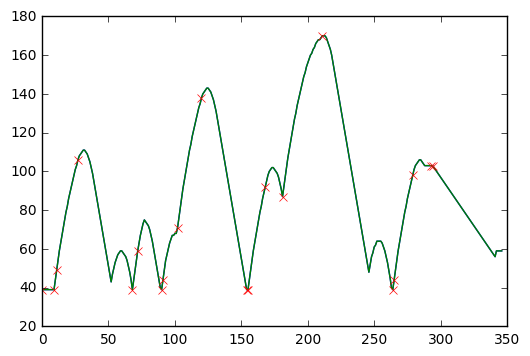

In [159]:
def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    for t, b in enumerate(button_masks):
        if b != last_mask:
            mask_times.append(t)
            last_mask = b
    return mask_times

times = button_change_times(track[:,3])

plt.plot(track[:,2])
plt.plot(np.array(times),track[np.array(times,dtype='int'),2],'rx')
plt.show()